<a href="https://colab.research.google.com/github/SsenabuyaDavid/DeforDetector/blob/main/Copy_of_chainsaw_further_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MAKERERE UNIVERSITY**

##**COLLEGE OF ENGINEERING, DESIGN, ART AND TECHNOLOGY**

##**SCHOOL OF ENGINEERING, DEPARTMENT OF ELECTRICAL AND COMPUTER ENGINEERING**

###AUDIO DOMAIN MACHINE LEARNING DEFORESTATION DETECTION AND ALERT SYSTEM

>PAUL WALYAULA ----- 20/U/0545 ----- BSTE

>DAVID SSENABULYA ---- 20/U/0544 ---- BSTE

This .ipynb for creating and training the Machine Learning Model that will be used in the detection of fuel powered chainsaws

##Install Relevant but Missing Libraries

In [ ]:
!pip install colorama
!pip install tensorflow-io
!pip install tensorflow_io
!pip install tensorflow_datasets
!pip install tf2onnx
!pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 13.7 MB/s eta 0:00:00


##Import Relevant Libraries / modules

In [ ]:
# importing relevant libraries/modules
import os  # to enable us navigate the system for files
import librosa  # to give us the audio stft(short time fourier transform) and other functions
import matplotlib.pyplot as plt  # to enable us visualize the waveforms
import tensorflow as tf
from colorama import Fore
import soundfile  # to enable us write the split audio files
import tensorflow_io as tfio  # to make it easier for us to input and output in tf
import numpy as np  # for necessary Mathematical calculations with arrays
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from google.colab import drive
import tensorflow_datasets as tfds
import tf2onnx
import onnxruntime as ort
import onnx

##Define Functions
1.   For Loading the audio file and making 10seconds split files
2.   For Creating spectrograms



For Loading and splitting

In [ ]:
# Defining a function for loading the audio file and making 10seconds audio files
def split_en_group(file_path, the_group):
    # Load & decode the audio into an array
    audio_file, sr = librosa.load(file_path, sr=None)

    # chop the audio file into 10 seconds clips if it's greater
    if librosa.get_duration(path=file_path) > 10:
        buffer = 10 * sr  # this is the number of samples in 10 seconds
        total_samples = len(audio_file)  # this is the total number of samples in the whole file
        written_samples = 0
        counter = 1

        while written_samples < total_samples:

            # if the buffer is greater than written samples, the remaining samples will be the buffer
            if buffer > (total_samples - written_samples):
                buffer = total_samples - written_samples

            # creating 10 seconds blocks of the file
            block = audio_file[written_samples: (written_samples + buffer)]
            block.astype(np.int16)
            out_filename = "split_" + str(counter) + "_" + os.path.basename(file_path).split('/')[-1]
            print(out_filename)

            # function for writing the split files to specific directories (Test, Positive, Negative)
            if the_group == "positive":
                # Write  the 10-second segment to a file in the positive directory
                soundfile.write(file=pos_splitFiles + "/" + out_filename, data=block, samplerate=sr, subtype="PCM_16")
                counter += 1
                written_samples += buffer

            elif the_group == "negative":
                # Write  the 10-second segment to a file in the negative directory
                soundfile.write(file=neg_splitFiles + "/" + out_filename, data=block, samplerate=sr, subtype="PCM_16")
                counter += 1
                written_samples += buffer

            elif the_group == "test":
                # Write  the 10-second segment to a file in the test directory
                soundfile.write(file=test_splitFiles + "/" + out_filename, data=block, samplerate=sr, subtype="PCM_16")
                counter += 1
                written_samples += buffer

            else:
                print(
                    Fore.RED + f"\n!!! The Specified Group does not exist !!! \n --- Check the Spelling >>{the_group}<< ---")
                exit()

    # Display the waveform of imported file
    '''plt.plot(audio_file)
    plt.show()'''

For creating Spectrograms

In [ ]:
# Define a function for creating the spectrogram
def create_spectrogram(file_path, label):
    # load the wav file
    file_content = tf.io.read_file(file_path)

    # decode wav
    wav, sr = tf.audio.decode_wav(file_content, desired_channels=1)

    wav = tf.squeeze(wav, axis=-1)
    sr = tf.cast(sr, dtype=tf.int64)

    # down sample from 44.1kHz to 16kHz
    #wav = tfio.audio.resample(wav, rate_in=sr, rate_out=16000)

    # grab the first 10s
    wav = wav[:160000]
    # pad zeros to the shorter clips
    zero_pads = tf.zeros([160000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_pads, wav], 0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32) #take 320 samples, do stft. skip 32 samples and take the next stft
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)

    return spectrogram, label

##Mounting Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


##Initialize the Directories for the split files

In [ ]:
# initialize the directories for the split files to be stored
pos_splitFiles = "/content/drive/MyDrive/Split_Files2/Positive"
neg_splitFiles = "/content/drive/MyDrive/Split_Files2/Negative"
test_splitFiles = "/content/drive/MyDrive/Split_Files2/Test"

##Create the Directories

In [ ]:
# the function for creating the initialized directories
try:
    os.makedirs(pos_splitFiles)
    os.makedirs(neg_splitFiles)
    os.makedirs(test_splitFiles)
    print("The paths have been created")
    no_file_exists = True
except FileExistsError:
    no_file_exists = False
    print("The paths exist")

if no_file_exists:
    # loop for creating and grouping the positive split files from our collected data
    for filename in os.listdir("/content/drive/MyDrive/parsed2/parsed_chainsaw"):
        filepath = os.path.join("/content/drive/MyDrive/parsed2/parsed_chainsaw", filename)
        if os.path.isfile(filepath):
            split_en_group(filepath, "positive")

    # loop for creating and grouping the negative split files from our collected data
    for filename in os.listdir("/content/drive/MyDrive/parsed2/parsed_non_chainsaw"):
        filepath = os.path.join("/content/drive/MyDrive/parsed2/parsed_non_chainsaw", filename)
        if os.path.isfile(filepath):
            split_en_group(filepath, "negative")

    # loop for creating and grouping the test split files from our collected data
    for filename in os.listdir("/content/drive/MyDrive/parsed2/parsed_mixed"):
        filepath = os.path.join("/content/drive/MyDrive/parsed2/parsed_mixed", filename)
        if os.path.isfile(filepath):
            split_en_group(filepath, "test")

The paths exist


In [ ]:
split_en_group("/content/drive/MyDrive/Split_Files2/noise_background-converted.wav","negative")

split_1_noise_background-converted.wav
split_2_noise_background-converted.wav
split_3_noise_background-converted.wav
split_4_noise_background-converted.wav
split_5_noise_background-converted.wav
split_6_noise_background-converted.wav
split_7_noise_background-converted.wav
split_8_noise_background-converted.wav
split_9_noise_background-converted.wav
split_10_noise_background-converted.wav
split_11_noise_background-converted.wav
split_12_noise_background-converted.wav
split_13_noise_background-converted.wav
split_14_noise_background-converted.wav
split_15_noise_background-converted.wav
split_16_noise_background-converted.wav
split_17_noise_background-converted.wav
split_18_noise_background-converted.wav
split_19_noise_background-converted.wav
split_20_noise_background-converted.wav
split_21_noise_background-converted.wav
split_22_noise_background-converted.wav
split_23_noise_background-converted.wav
split_24_noise_background-converted.wav
split_25_noise_background-converted.wav
split_26_

Dont Exceed 300 splits

In [ ]:
split_en_group("/content/drive/MyDrive/Split_Files2/chainsaw1.wav","positive")

split_1_chainsaw1.wav
split_2_chainsaw1.wav
split_3_chainsaw1.wav
split_4_chainsaw1.wav
split_5_chainsaw1.wav
split_6_chainsaw1.wav
split_7_chainsaw1.wav
split_8_chainsaw1.wav
split_9_chainsaw1.wav
split_10_chainsaw1.wav
split_11_chainsaw1.wav
split_12_chainsaw1.wav
split_13_chainsaw1.wav
split_14_chainsaw1.wav
split_15_chainsaw1.wav
split_16_chainsaw1.wav
split_17_chainsaw1.wav
split_18_chainsaw1.wav
split_19_chainsaw1.wav
split_20_chainsaw1.wav
split_21_chainsaw1.wav
split_22_chainsaw1.wav
split_23_chainsaw1.wav
split_24_chainsaw1.wav
split_25_chainsaw1.wav
split_26_chainsaw1.wav
split_27_chainsaw1.wav
split_28_chainsaw1.wav
split_29_chainsaw1.wav
split_30_chainsaw1.wav
split_31_chainsaw1.wav
split_32_chainsaw1.wav
split_33_chainsaw1.wav
split_34_chainsaw1.wav
split_35_chainsaw1.wav
split_36_chainsaw1.wav
split_37_chainsaw1.wav
split_38_chainsaw1.wav
split_39_chainsaw1.wav
split_40_chainsaw1.wav
split_41_chainsaw1.wav
split_42_chainsaw1.wav
split_43_chainsaw1.wav
split_44_chainsaw1.w

##Create TensorFlow Dataset

In [ ]:
# creating the TensorFlow data sets
pos = tf.data.Dataset.list_files("/content/drive/MyDrive/Split_Files2/Positive/*.wav")
neg = tf.data.Dataset.list_files("/content/drive/MyDrive/Split_Files2/Negative/*.wav")

# Adding labels to the positive and negative datasets
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)  # combine the positive and negative datasets into 1 dataset

##Create TensorFlow data pipepline

In [ ]:
# creating the tensorflow data pipeline
data = data.map(create_spectrogram)  # mapping our function that returns the spectrogram and label
data = data.cache()  # caching the data
data = data.shuffle(buffer_size=5)  # shuffling or mixing the dataset
data = data.batch(16)  # creating batches of 16 to train on at a time
data = data.prefetch(8)  # fetching 8 batches at a time

# divide dataset into training and testing partitions
trn = int(len(data) * 0.7)  # using 70% of dataset for training
tst = len(data) - trn  # using 30% of dataset for testing

train = data.take(trn)  # training data
#data = data.cache()  # caching the data
test = data.skip(trn).take(tst)  # testing data

#Import the Model
*   View The Model
*   Track the training
*   Save the new one
*   Convert to TFlite

In [ ]:
# Model Importation
model = load_model('/content/drive/MyDrive/TFmodels/chainsaw.keras')

# viewing the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 4989, 255, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 4987, 253, 16)     2320      
                                                                 
 conv2d_2 (Conv2D)           (None, 4985, 251, 16)     2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 2492, 125, 16)     0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 4984000)           0         
                                                                 
 dense (Dense)               (None, 1)                 4984001   
                                                        

##Model Training

In [ ]:
# training, tracking the loss and KPI plots
histore = model.fit(train, epochs=12, validation_data=test)

Epoch 1/12
23/23 [==============================] - 178s 7s/step - loss: 0.0321 - recall: 1.0000 - precision: 0.9904 - val_loss: 0.0272 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/12
23/23 [==============================] - 16s 695ms/step - loss: 0.0243 - recall: 1.0000 - precision: 0.9856 - val_loss: 0.0202 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/12
23/23 [==============================] - 16s 695ms/step - loss: 0.0183 - recall: 1.0000 - precision: 0.9952 - val_loss: 0.0228 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/12
23/23 [==============================] - 16s 701ms/step - loss: 0.0142 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0207 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 5/12
23/23 [==============================] - 16s 706ms/step - loss: 0.0129 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0196 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 6/12
23/23 [=============================

###Model tracking

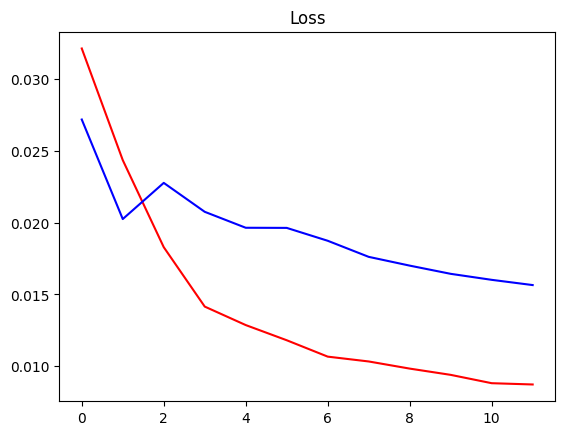

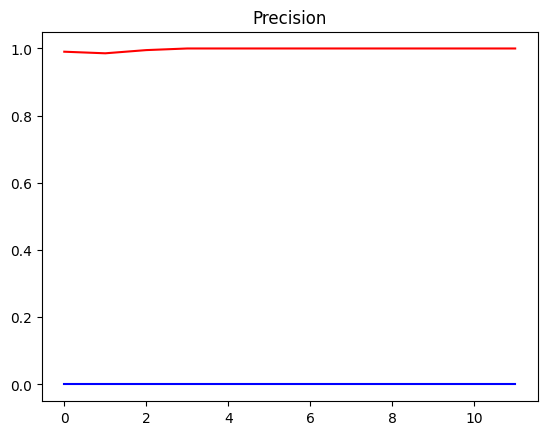

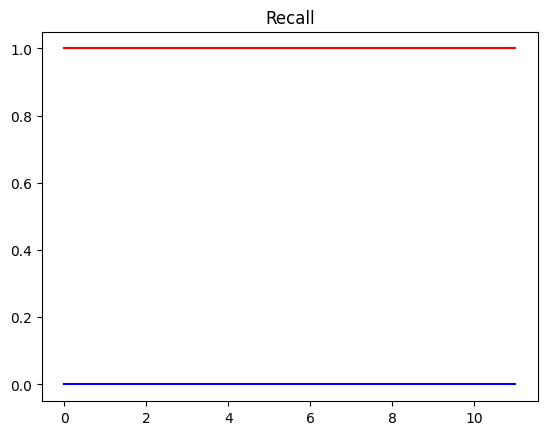

In [ ]:
# ploting the graphs

plt.title('Loss') # for the loss plot
plt.plot(histore.history['loss'], 'r')
plt.plot(histore.history['val_loss'], 'b')
plt.show()

plt.title('Precision') # for the precision plot
plt.plot(histore.history['precision'], 'r')
plt.plot(histore.history['val_precision'], 'b')
plt.show()

plt.title('Recall') # for the recall plot
plt.plot(histore.history['recall'], 'r')
plt.plot(histore.history['val_recall'], 'b')
plt.show()

##Save the model to google drive

In [ ]:
# code to save model as keras to googledrive
model.save('/content/drive/MyDrive/TFmodels/chainsaw.keras')

In [ ]:
#save the model as ".saved model", for later conversion to tf_lite
tf.saved_model.save(model, '/content/drive/MyDrive/TFmodels/chainsaw')

#Conversions

##Convert the model to Tensorflow lite version

In [ ]:
# Convert the model to tflite
converter = tf.lite.TFLiteConverter.from_saved_model('/content/drive/MyDrive/TFmodels/chainsaw') # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('/content/drive/MyDrive/TFmodels/chainsaw_detection.tflite', 'wb') as f:
  f.write(tflite_model)

## Create a model with preprocess functionality for ONNX

In [ ]:
# create a preprocessing layer to be included on thy model

class PreprocessingLayer(tf.keras.layers.Layer):
  def __init__(self, output_dim=(None, 4991,257,1), **kwargs):
    self.output_dim = output_dim
    super(PreprocessingLayer, self).__init__(**kwargs)

  def build(self, input_shape=(None, 160000,1)):
    super(PreprocessingLayer, self).build(input_shape)

  def call(self, inputs, training=False):
    def create_spectrogram(wav):

      '''# load the wav file
      file_content = tf.io.read_file(filepath)
      # decode wav
      wav, sr = tf.audio.decode_wav(file_content, desired_channels=1)'''

      wav = tf.squeeze(wav, axis=-1)

      '''#sr = tf.cast(sr, dtype=tf.int64)
      # down sample from 44.1kHz to 16kHz
      #wav = tfio.audio.resample(wav, rate_in=sr, rate_out=16000)'''

      # grab the first 10s
      wav = wav[:160000]
      # pad zeros to the shorter clips
      zero_pads = tf.zeros([160000] - tf.shape(wav), dtype=tf.float32)
      wav = tf.concat([zero_pads, wav], 0)
      spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
      spectrogram = tf.abs(spectrogram)
      spectrogram = tf.expand_dims(spectrogram, axis=2)

      return spectrogram

    #map the function to the inputs
    preprocessed = tf.map_fn(create_spectrogram, inputs, fn_output_signature=tf.float32)

    return preprocessed

Stacking the preprocessing layer onto the model

In [ ]:
# code to add my new layer infront of the existing model
pre_model = tf.keras.Sequential([
    PreprocessingLayer(),
    model,
])

#Build the Model
pre_model.build(input_shape=(None,160000,1))
pre_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocessing_layer (Prepr  (None, 4991, 257, 1)      0         
 ocessingLayer)                                                  
                                                                 
 sequential (Sequential)     (None, 1)                 4988801   
                                                                 
Total params: 4988801 (19.03 MB)
Trainable params: 4988801 (19.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Convert to ONNX model

In [ ]:
input_signature = [tf.TensorSpec([None,160000,1], tf.float32, name='input_layer')]
onnx_model, _ = tf2onnx.convert.from_keras(pre_model, input_signature, opset=18)
onnx.save(onnx_model, "/content/drive/MyDrive/TFmodels/chainsaw_detection.onnx")

#Make predictions

Function for creating non labled spectrograms

In [ ]:
# Define a function for creating the spectrogram
def spectrogram_no_label(file_path):
    # load the wav file
    file_content = tf.io.read_file(file_path)

    # decode wav
    wav, sr = tf.audio.decode_wav(file_content, desired_channels=1)

    wav = tf.squeeze(wav, axis=-1)
    sr = tf.cast(sr, dtype=tf.int64)

    # down sample from 44.1kHz to 16kHz
    #wav = tfio.audio.resample(wav, rate_in=sr, rate_out=16000)

    # grab the first 10s
    wav = wav[:160000]

    # pad zeros to the shorter clips
    zero_pads = tf.zeros([160000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_pads, wav], 0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    plt.plot(spectrogram)
    plt.show()
    spectrogram = tf.abs(spectrogram)
    plt.plot(spectrogram)
    plt.show()
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

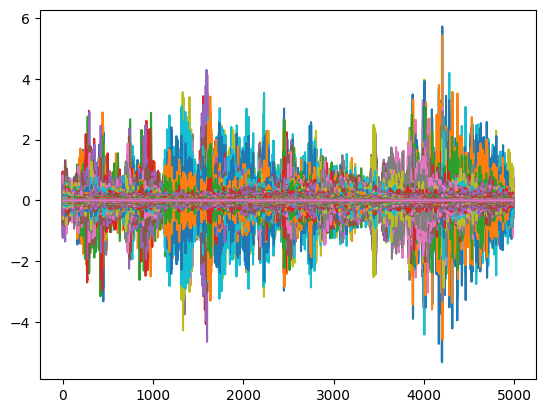

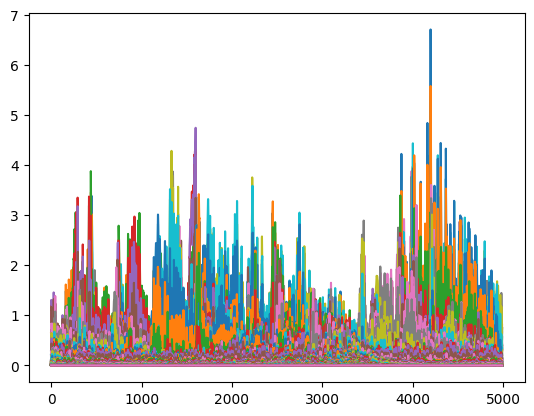

<tf.Tensor: shape=(4991, 257, 1), dtype=float32, numpy=
array([[[7.2205439e-06],
        [2.1945816e-04],
        [7.5346288e-05],
        ...,
        [2.3853111e-03],
        [1.6276039e-03],
        [1.2095524e-03]],

       [[4.2289495e-05],
        [1.7838158e-04],
        [1.8146694e-04],
        ...,
        [2.2931790e-03],
        [1.5881951e-03],
        [6.8797916e-04]],

       [[6.9770962e-05],
        [1.5628355e-04],
        [2.5132697e-04],
        ...,
        [2.0737962e-03],
        [1.7061086e-03],
        [3.7584826e-04]],

       ...,

       [[2.3278948e-03],
        [1.8702601e-03],
        [1.1232890e-03],
        ...,
        [2.5037311e-03],
        [1.9858615e-03],
        [1.5729088e-03]],

       [[2.1129502e-03],
        [1.6781284e-03],
        [8.0947514e-04],
        ...,
        [2.5560961e-03],
        [1.7036921e-03],
        [7.0791412e-04]],

       [[2.0508356e-03],
        [1.1897074e-03],
        [4.4119766e-04],
        ...,
        [2.1939902

In [ ]:
spectrogram_no_label('/content/drive/MyDrive/Split_Files2/Negative/split_148_wildlife.wav')

Predicting on Keras model

In [ ]:
# code that will use the trained model to make predictions basing on given file paths
drive.mount('/content/drive')
# load the model
model = load_model('/content/drive/MyDrive/TFmodelsN/chainsaw.keras')

# load the test data
test_data = tf.data.Dataset.list_files("/content/drive/MyDrive/Split_Files2/Test/*.wav")
test_data = test_data.map(spectrogram_no_label)
test_data = test_data.batch(16)

# make predictions
predictions = model.predict(test_data)

# print the predictions
print(predictions)

Predictions on preprocess layer model

In [ ]:
# get the input shape of my model
pre_model.input_shape

###now leme make a prediction

# load the wav file
file_content = tf.io.read_file("/content/drive/MyDrive/Split_Files2/Positive/split_335_aupclean2.wav")
# decode wav
wavo, sr = tf.audio.decode_wav(file_content, desired_channels=1)

#making the prediction
prediction = pre_model.predict(tf.expand_dims(wavo,axis=0)) #here
print(prediction)

Predictions on Tensorflow Lite model

In [ ]:
# Import the saved TensorFlow Lite model
drive.mount('/content/drive')
interpreter = tf.lite.Interpreter(model_path='/content/drive/MyDrive/TFmodels/chainsaw_detection.tflite')

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load test data
test_data = tf.data.Dataset.list_files("/content/drive/MyDrive/Split_Files/Test/*.wav")
file_location = test_data
test_data = test_data.map(spectrogram_no_label)
test_data = test_data.batch(1)

# Make predictions
predictions = []
for test_batch in test_data:
    interpreter.allocate_tensors()
    interpreter.set_tensor(input_details[0]['index'], test_batch)
    interpreter.invoke()
    predictions.extend(interpreter.get_tensor(output_details[0]['index']))
n=0
# Print predictions and file paths
for f in file_location:
  f = next(iter(file_location))
  print("\nEvent")
  print(f)
  print(f"has {predictions[n][0]} probability of chainsaw activity\n")
  n+=1


#Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

# Load the test dataset
# creating the TensorFlow data sets
pos = tf.data.Dataset.list_files("/content/drive/MyDrive/Split_Files2/Positivetb/*.wav")
neg = tf.data.Dataset.list_files("/content/drive/MyDrive/Split_Files2/Negativetb/*.wav")

test_labels=[] #for the actual labels
for i in pos:
  test_labels.append(1)
for i in neg:
  test_labels.append(0)

# Adding labels to the positive and negative datasets
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
test_data = positives.concatenate(negatives)  # combine the positive and negative datasets into 1 dataset

# creating the tensorflow data pipeline
test_data = test_data.map(create_spectrogram)  # mapping our function that returns the spectrogram and label
test_data = test_data.cache()  # caching the data
test_data = test_data.batch(16)  # creating batches of 16 to train on at a time
test_data = test_data.prefetch(8)  # fetching 8 batches at a time

In [ ]:
# Make predictions
predictions = model.predict(test_data)

38/38 [==============================] - 126s 3s/step


In [ ]:
#creating an array with rounded prediction values

chainsaw_predictions =[]

#loop for rounding the predictions
for value in predictions:
  if value >= 0.85:
    chainsaw_predictions.append(1)
  else:
    chainsaw_predictions.append(0)

In [ ]:
cm = confusion_matrix(y_true=test_labels , y_pred=chainsaw_predictions)

Function to print and Plot Confusion Matrix

In [ ]:
def plot_confusion_matrix(cm, classes, normalise=False, title="Confusion Matrix", cmap=plt.cm.Blues):
  plt.imshow(cm,interpolation="nearest",cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalise:
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    print("Normalised confusion Matrix")
  else:
    print('Confusion matrix, without normalization')

  print(cm)

  thresh = cm.max()/2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i,cm[i,j],
             horizontalalignment='center',
             color='white' if cm[i,j]>thresh else 'black'
             )
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted label')

plot the confusion matrix

Confusion matrix, without normalization
[[228 103]
 [ 31 245]]


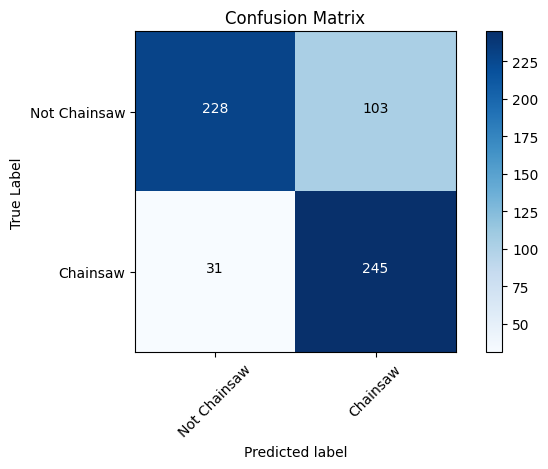

In [ ]:
cm_plot_labels = ['Not Chainsaw', 'Chainsaw']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title = 'Confusion Matrix')

# For the app

In [ ]:
# Define a function for creating the spectrogram

def spect_predict(file_path):
    # load the wav file
    file_content = tf.io.read_file(file_path)

    # decode wav
    wav, sr = tf.audio.decode_wav(file_content, desired_channels=1)

    wav = tf.squeeze(wav, axis=-1)
    #sr = tf.cast(sr, dtype=tf.int64)

    # down sample from 44.1kHz to 16kHz
    #wav = tfio.audio.resample(wav, rate_in=sr, rate_out=16000)

    # grab the first 10s
    wav = wav[:160000]

    # pad zeros to the shorter clips
    #zero_pads = tf.zeros([160000] - tf.shape(wav), dtype=tf.float32)
    #wav = tf.concat([zero_pads, wav], 0)

    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    spectrogram = tf.expand_dims(spectrogram, axis=0)

    #load the lite interpreter
    interpreter = tf.lite.Interpreter(model_path='/content/drive/MyDrive/TFmodels/chainsaw_detection.tflite')

    # Get input and output tensors
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    #set and predict
    input_shape = input_details[0]['shape']
    interpreter.set_tensor(input_details[0]['index'], spectrogram)

    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])

    return output_data

In [ ]:
spect_predict("/content/drive/MyDrive/Split_Files/Negative/split_3_241130__jesu_tenoh__forest-07.wav")

array([[0.08538777]], dtype=float32)